## Imports

In [27]:
import pandas as pd
import numpy as np
import sqlite3
import os
import joblib

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ML evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# CELL 2: Load Processed Data
# ==============================================================================
# --- Configuration ---
DB_PATH = '../database/ELECTIONS.db'
MODELS_DIR = '../models'

print("Loading processed data from the database...")
try:
    con = sqlite3.connect(DB_PATH)
    train_df = pd.read_sql_query('SELECT * FROM PROCESSED_TRAIN_DATA', con)
    test_df = pd.read_sql_query('SELECT * FROM PROCESSED_TEST_DATA', con)
    con.close()
    print(f"Loaded {len(train_df)} training rows and {len(test_df)} testing rows.")
except Exception as e:
    print(f"Error loading data: {e}")
    # Si le chargement échoue, il est inutile de continuer
    exit()

Loading processed data from the database...
Loaded 652 training rows and 94 testing rows.


In [29]:
# CELL 3: Separate Features (X) and Target (y)
# ==============================================================================
print("\nSeparating features and target...")
TARGET_COL = 'WINNER_encoded'
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]
X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]
print("✅ Done.")


Separating features and target...
✅ Done.


In [30]:
# CELL 4: Define, Train, and Evaluate Models
# ==============================================================================
print("\n--- Training and Evaluating Models ---")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    # Nous utilisons la précision "weighted" qui est adaptée pour une classification multi-classes
    precision = precision_score(y_test, predictions, average='weighted')
    
    results[name] = {'model': model, 'accuracy': accuracy, 'precision': precision}
    
    print(f"✅ {name} -> Accuracy: {accuracy:.4f}, Weighted Precision: {precision:.4f}")


--- Training and Evaluating Models ---

Training Logistic Regression...
✅ Logistic Regression -> Accuracy: 0.2979, Weighted Precision: 0.6213

Training Random Forest...
✅ Random Forest -> Accuracy: 0.4787, Weighted Precision: 0.6598

Training Decision Tree...
✅ Decision Tree -> Accuracy: 0.4468, Weighted Precision: 0.6109

Training SVM...
✅ SVM -> Accuracy: 0.2340, Weighted Precision: 0.6298


In [31]:
# CELL 5: Visualize Model Performance
# ==============================================================================
# Créer un DataFrame avec les résultats pour une visualisation facile
accuracy_df = pd.DataFrame([
    {'Model': name, 'Accuracy': res['accuracy']}
    for name, res in results.items()
]).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

/var/folders/sp/w9p124nd6jb9srzf94f0v2q80000gn/T/ipykernel_14491/4139775498.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')


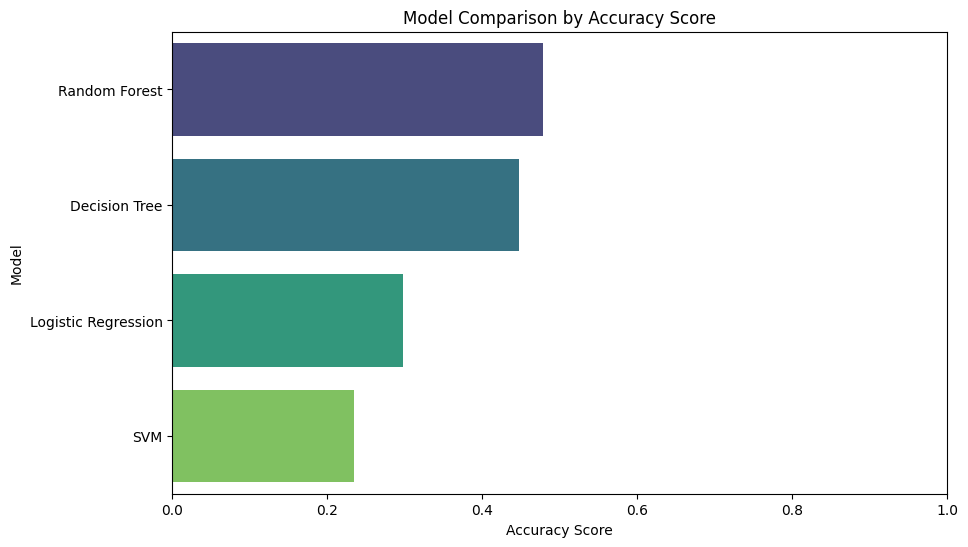


--- Model Performance Summary ---
                 Model  Accuracy
0        Random Forest  0.478723
1        Decision Tree  0.446809
2  Logistic Regression  0.297872
3                  SVM  0.234043


In [32]:
# CELL 5: Visualize Model Performance
# ==============================================================================
# Créer un DataFrame avec les résultats pour une visualisation facile
accuracy_df = pd.DataFrame([
    {'Model': name, 'Accuracy': res['accuracy']}
    for name, res in results.items()
]).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')
plt.title('Model Comparison by Accuracy Score')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0, 1.0)
plt.show()

print("\n--- Model Performance Summary ---")
print(accuracy_df)

In [33]:
# CELL 6: Automatically Select and Save the Best Model
# ==============================================================================
# --- Sélection automatique du meilleur modèle ---
# Nous prenons le premier modèle du DataFrame, car il est trié par 'Accuracy' décroissante.
best_model_name = accuracy_df.loc[0, 'Model']
best_model_object = results[best_model_name]['model']
best_model_accuracy = accuracy_df.loc[0, 'Accuracy']

print(f"\n🏆 Best model selected automatically: '{best_model_name}' with an accuracy of {best_model_accuracy:.4f}.")


🏆 Best model selected automatically: 'Random Forest' with an accuracy of 0.4787.


In [34]:
# --- Sauvegarde ---
# Créer le dossier 'models' s'il n'existe pas
os.makedirs(MODELS_DIR, exist_ok=True)

# Définir le chemin de sauvegarde. Le nom du fichier inclut le nom du modèle pour plus de clarté.
model_filename = f"{best_model_name.lower().replace(' ', '_')}_predictor.joblib"
model_path = os.path.join(MODELS_DIR, model_filename)

# Sauvegarder l'objet modèle
joblib.dump(best_model_object, model_path)

print(f"\n✅ Best model saved successfully to: {model_path}")


✅ Best model saved successfully to: ../models/random_forest_predictor.joblib
